In [2]:
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
import mrcnn
from mrcnn.utils import Dataset
from mrcnn.model import MaskRCNN
import numpy as np
from numpy import zeros
from numpy import asarray
import colorsys
import argparse
import imutils
import random
import cv2
import os
import time
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from keras.models import load_model
from os import listdir
from xml.etree import ElementTree

%matplotlib inline


# https://machinelearningmastery.com/how-to-train-an-object-detection-model-with-keras/
# https://towardsdatascience.com/object-detection-using-mask-r-cnn-on-a-custom-dataset-4f79ab692f6d
# summary and notes : https://www.shortscience.org/paper?bibtexKey=journals/corr/HeGDG17#aleju
# main paper : https://arxiv.org/pdf/1703.06870v3.pdf

# https://engineering.matterport.com/splash-of-color-instance-segmentation-with-mask-r-cnn-and-tensorflow-7c761e238b46

# memory optimizing technique :https://github.com/matterport/Mask_RCNN/wiki
# rpn https://towardsdatascience.com/region-proposal-network-a-detailed-view-1305c7875853
# https://medium.com/@smallfishbigsea/faster-r-cnn-explained-864d4fb7e3f8

Using TensorFlow backend.
/home/jyoti/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [3]:
import tensorflow as tf
tf.__version__

'2.0.0'

In [4]:
class CrossingDataset(Dataset):
    

    # # load the dataset definitions
    def load_dataset(self,  dataset_dir, is_train=True):

         # Add classes. We have only one class to add.
        self.add_class('dataset', 1, 'c')
        #self.add_class('dataset', 2, 'n')
        
        # define data locations
        if is_train:
            images_dir = dataset_dir + '/image/'
            annotations_dir = dataset_dir + '/annot/'
        else:
            images_dir = dataset_dir + '/image/'
            annotations_dir = dataset_dir + '/annot/'
            

        # Iterate through all files in the folder to add class, images and annotaions
        for filename in listdir(annotations_dir):
            #print(filename)
            tree = ElementTree.parse(annotations_dir + filename)
            # get the root of the document
            root = tree.getroot()
            
            labels = list()
            
            for obj in root.findall('.//object'):
                label = obj.find('name').text
                labels.append(label)
                
            if 'c' in labels:
                image_id = filename[:-4]
                img_path = images_dir + image_id + '.png'
                ann_path = annotations_dir + filename
                # add to dataset
                self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
                labels = list()
        

    
    # extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        
        labels = []
        boxes = []
        #print(root.findall('.//object'))
        for obj in root.findall('.//object'):
            label = obj.find('name').text
            if label == 'c':
                labels.append(label)
                for box in obj.findall('bndbox'):
                    xmin = int(box.find('xmin').text)
                    ymin = int(box.find('ymin').text)
                    xmax = int(box.find('xmax').text)
                    ymax = int(box.find('ymax').text)
                    coors = [xmin, ymin, xmax, ymax]
                boxes.append(coors)
        
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        
        return boxes, width, height, labels


    # load the masks for an image
    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
     """
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
    
        # load XML
        boxes, w, h , labels = self.extract_boxes(path)
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index(labels[i]))
        return masks, asarray(class_ids, dtype='int32')

# load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']


In [5]:
#  prepare train set
train_set = CrossingDataset()
train_set.load_dataset('./LABEL_IMG/hel_espoo_images/train', is_train=True)
train_set.prepare()
print('Number of images in train set is {}'.format(len(train_set.image_ids)))

Number of images in train set is 1126


In [6]:
#  prepare test set 
test_set = CrossingDataset()
test_set.load_dataset('./LABEL_IMG/hel_espoo_images/test', is_train=False)
test_set.prepare()
print('Number of images in test set is {}'.format(len(test_set.image_ids)))

Number of images in test set is 88


In [7]:
# check dataset by loading image 
image_id = 110
image = train_set.load_image(image_id)
print(image.shape)
print(train_set.image_reference(image_id))

(800, 1000, 3)
./LABEL_IMG/hel_espoo_images/train/image/outside_235.png


In [8]:
# load image mask
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)
print(class_ids)

(800, 1000, 3)
[1 1 1]


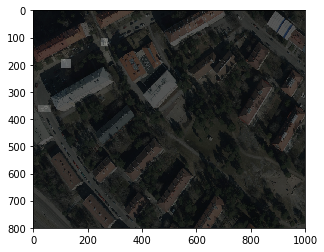

In [9]:
plt.imshow(image)
    # plot all masks
for j in range(mask.shape[2]):
    plt.imshow(mask[:, :, j], cmap='gray', alpha=0.3)

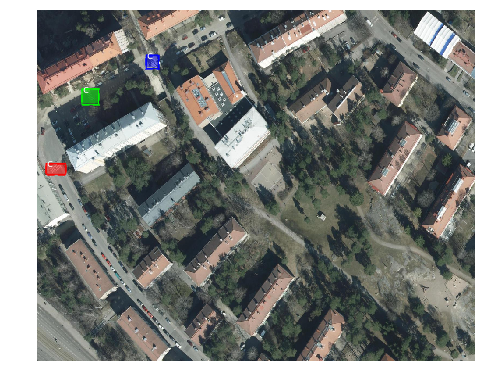

In [10]:
# define image id
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
image_id = 110
# load the image
image = train_set.load_image(image_id)
# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names, figsize=(8,8))

In [12]:
class CrossingConfig(Config):
    NAME = "only_crossings"
    # Number of classes (background + crossings )
    NUM_CLASSES = 1+1
    
    # Number of training steps per epoch
    
    STEPS_PER_EPOCH = 563
    IMAGE_MIN_DIM = 800
    IMAGE_MAX_DIM = 1024
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)
    DETECTION_MIN_CONFIDENCE = 0.80
    
     # setting Max ground truth instances
    MAX_GT_INSTANCES= 10
    
    TRAIN_ROIS_PER_IMAGE = 200
 
# prepare config
config = CrossingConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [ ]:
# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)

In [ ]:
# load weights (mscoco)
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
# train weights (output layers or 'heads')
model.train(train_set, test_set , learning_rate=config.LEARNING_RATE, epochs=100, layers='heads', augmentation = imgaug.augmenters.Sometimes(0.5, [
                    imgaug.augmenters.Fliplr(0.5)]))

In [72]:
class CrossingConfig(Config):
    NAME = "only_crossings"
    # Number of classes (background + crossings )
    NUM_CLASSES = 1+1
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 1100
    DETECTION_MIN_CONFIDENCE = 0.70
     # setting Max ground truth instances
    MAX_GT_INSTANCES=7
    
    IMAGES_PER_GPU = 1
    
    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels
    # RPN_ANCHOR_SCALES              (32, 64, 128, 256, 512)
    
    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128
    
 
# prepare config
cfg = CrossingConfig()
#config.display()

In [73]:
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
model.load_weights('mask_rcnn_only_crossings_0098.h5', by_name=True)

In [74]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

In [75]:
img = load_img('./LABEL_IMG/hel_espoo_images/test/image/outside_12.png')
# nz2.PNG
img = img_to_array(img)
#print(img.shape)
#print(img.dtype)
# detecting objects in the image
result= model.detect([img])

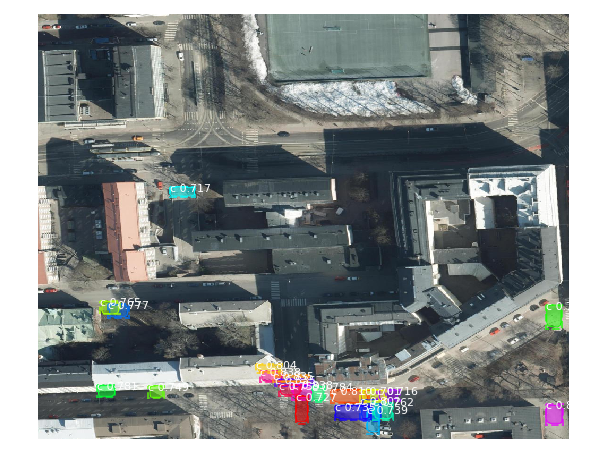

In [76]:
r = result[0]
visualize.display_instances(img, r['rois'], r['masks'],r['class_ids'],test_set.class_names, r['scores'],figsize=(13,8))